# Train-Test Split

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from collections import defaultdict
from sklearn.metrics import roc_auc_score, f1_score
from fastai.text import *

seed = 41
np.random.seed(seed)
torch.manual_seed(seed)

import warnings
warnings.filterwarnings(action='ignore')

In [16]:
path = Path('/home/paperspace/suicides')
lm_path = Path('data/lm/')

In [17]:
df = pd.read_csv(path/'data/std_format_raw_data.csv',index_col=0)
labels = df['labels'].values.copy()
tokens = np.load(lm_path/'tmp'/'tokens.npy')

In [18]:
# shuffle tokens and labels together
idx = np.random.permutation(len(labels))
labels = labels[idx]
tokens = tokens[idx]

In [19]:
num_labels_1 = np.sum(labels==1)
ratio = 1 # ratio of 0 labels (non-suicide) to 1 labels (suicide)
tokens_label_1 = list(tokens[labels==1])
labels_label_1 = list(labels[labels==1])
tokens_label_0 = list(tokens[labels==0][:ratio*(num_labels_1+1)])
labels_label_0 = list(labels[labels==0][:ratio*(num_labels_1+1)])
tokens_balanced = tokens_label_1+tokens_label_0
labels_balanced = np.array(labels_label_1+labels_label_0)

In [20]:
int_to_str = pickle.load(open(lm_path/'tmp'/'int_to_str.pkl', 'rb'))
str_to_int = defaultdict(lambda:0, {v:k for k,v in enumerate(int_to_str)})

In [21]:
X = np.array([[str_to_int[o] for o in p] for p in tokens_balanced])
y = labels_balanced

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=seed)

In [22]:
if ratio>1:
    # naively random oversampling positive labels in training set (not test set!!!) to make data balanced
    is_0 = np.where(y_train == 0)[0]
    is_1 = np.where(y_train == 1)[0]
    is_1_up = np.random.choice(is_1, size=len(is_0), replace=True)
    X_train_up = np.concatenate((X_train[is_1_up], X_train[is_0]))
    y_train_up = np.concatenate((y_train[is_1_up], y_train[is_0]))

    # reshuffle training data
    idx = np.random.permutation(len(y_train_up))
    X_train_up = X_train_up[idx]
    y_train_up = y_train_up[idx]
else:
    X_train_up = X_train
    y_train_up = y_train

# Training

In [29]:
bptt = 70
embedding_size = 400
num_hidden = 1150
num_layers = 3
vocab_size = len(int_to_str)
bs = 48
dropouts = np.array([0.4,0.5,0.05,0.3,0.4])*0.7
num_labels = y_test.max()+1
opt = partial(optim.Adam, betas=(0.7, 0.99))
lr = 3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
wd = 1e-7

In [24]:
dataset_train = TextDataset(X_train_up, y_train_up)
dataset_test = TextDataset(X_test, y_test)

sampler_train = SortishSampler(X_train_up, key=lambda x: len(X_train_up[x]), bs=bs//2)
sampler_test = SortSampler(X_test, key=lambda x: len(X_test[x]))

dl_train = DataLoader(dataset_train, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=sampler_train)
#dl_test = DataLoader(dataset_test, bs, transpose=True, num_workers=1, pad_idx=1, sampler=sampler_test)
dl_test = DataLoader(dataset_test, bs, transpose=True, num_workers=1, pad_idx=1, sampler=None, shuffle=False)

model_data = ModelData(path, dl_train, dl_test)

In [25]:
model = get_rnn_classifier(bptt, 20*70, num_labels, vocab_size, emb_sz=embedding_size, n_hid=num_hidden, 
                           n_layers=num_layers, pad_token=1, layers=[embedding_size*3, 50, 2], 
                           drops=[dropouts[4], 0.1],dropouti=dropouts[0], wdrop=dropouts[1], 
                           dropoute=dropouts[2], dropouth=dropouts[3])

In [26]:
def auc(preds,targs):
    try:
        preds = preds.cpu().numpy()
        preds = np.argmax(preds,axis=1)
        targs = targs.cpu().numpy().flatten()
        roc = roc_auc_score(targs,preds)
    except:
        print('Value error occured, setting auc=-1')
        roc = -1
    return roc
def F1(preds,targs):
    try:
        preds = preds.cpu().numpy()
        preds = np.argmax(preds,axis=1)
        targs = targs.cpu().numpy().flatten()
        f1 = f1_score(targs,preds)
    except:
        print('Value error occured, setting F1=-1')
        f1 = -1
    return f1

In [27]:
learner = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt, metrics=[accuracy,F1,auc])
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 25.
learner.load_encoder('lm_last_fit_full_encoder')
learner.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/62 [00:00<?, ?it/s]                     


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 84%|████████▍ | 52/62 [01:04<00:12,  1.24s/it, loss=1.58] 


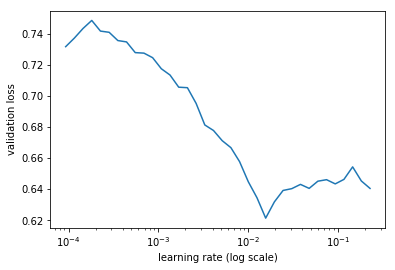

In [28]:
learner.lr_find(lrs/1000)
learner.sched.plot()

In [30]:
learner.fit(lrs, 1, wds=wd, cycle_len=10, use_clr=(8,3))
#learner.save('clf_tmp1')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   F1         auc        
    0      0.559315   0.621766   0.675749   0.61645    0.66775   
    1      0.505593   0.591342   0.746594   0.644038   0.726606  
    2      0.496297   0.513562   0.757493   0.666804   0.73991   
    3      0.504554   0.493959   0.754768   0.674524   0.738005  
    4      0.48473    0.533696   0.743869   0.636558   0.725782  
    5      0.488727   0.470733   0.754768   0.660888   0.737675  
    6      0.464358   0.489378   0.762943   0.672949   0.745439  
    7      0.469297   0.49725    0.746594   0.644673   0.727852  
    8      0.43013    0.488344   0.752044   0.647589   0.731818  
    9      0.465323   0.518435   0.749319   0.638491   0.728348  



[array([ 0.51844]),
 0.74931879670483537,
 0.63849082702437776,
 0.72834813975593005]

In [31]:
learner.freeze_to(-2)
learner.fit(lrs, 1, wds=wd, cycle_len=10, use_clr=(8,3))
#learner.save('clf_tmp2')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   F1         auc        
    0      0.429842   0.508345   0.73842    0.612211   0.717031  
    1      0.48086    0.546719   0.743869   0.649245   0.724528  
    2      0.445901   0.515684   0.760218   0.659899   0.740114  
    3      0.459717   0.585774   0.73842    0.603009   0.71423   
    4      0.440359   0.602096   0.749319   0.739099   0.751444  
    5      0.422634   0.508611   0.771117   0.672519   0.750724  
    6      0.411085   0.495621   0.79564    0.730642   0.781097  
    7      0.398806   0.671865   0.754768   0.63705    0.734853  
    8      0.381756   0.450636   0.79564    0.733339   0.781765  
    9      0.372775   0.419201   0.809264   0.752968   0.796199  



[array([ 0.4192]),
 0.80926430322818599,
 0.75296757699470684,
 0.79619898970514624]

In [32]:
learner.unfreeze()
learner.fit(lrs, 1, wds=wd, cycle_len=5, use_clr=(8,3))
#learner.save('clf_tmp3')

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   F1         auc        
    0      0.35443    0.469472   0.80654    0.759192   0.795974  
    1      0.394834   0.612359   0.798365   0.730233   0.783135  
    2      0.359095   0.393794   0.836512   0.791179   0.826786  
    3      0.328546   0.35958    0.841962   0.812326   0.836945  
    4      0.297317   0.328974   0.850136   0.817019   0.843027  



[array([ 0.32897]),
 0.85013623507211256,
 0.81701852731820823,
 0.84302684206460721]

# Model Eval

In [ ]:
#learner.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))
#learner.load('clf_tmp2')

In [ ]:
preds = learner.predict()
preds.shape,y_test.shape

In [ ]:
yhat = np.argmax(np.exp(preds),axis=1)
np.sum(yhat==y_test)/len(y_test)

In [ ]:
#np.max(np.exp(preds[:,-1]))

In [ ]:
# get predictions
preds_dist, preds = learner.predict_with_targs()

# prepare for accuracy measurement
preds = preds.flatten()
golds = learner.data.val_y

print(np.sum(preds==golds)/len(golds))

In [ ]:
preds[:10],golds[:10],y_test[:10]

In [ ]:
#print(np.sum(np.argmax(preds_dist[:,1],axis=1)==golds)/len(golds))
preds_dist[:10]

In [ ]:
??predict_with_targs_

In [ ]:
#tmp = predict_with_targs_(learner.model,dl_test)
p,t = tmp
ntmp = np.concatenate(p), np.concatenate(t)
ntmp[:10]

In [ ]:
i=0
for *x,y in iter(dl_test):
    print(to_np(learner.model(*VV(x))),y)
    i+=1
    if i>10:
        break

In [ ]:
tup = learner.model(*VV(x))#.data).float()

In [ ]:
len(tup[2])